# Quick Start

## Imports and Paths


In [192]:
import os, sys
import numpy as np


script_path = os.getcwd()
project_path = os.path.join(script_path, '..')
sys.path.append(project_path)

## Installation

In [193]:
# pip install db-robust-clust



To see the available versions of the package go to the release history at PyPi: https://pypi.org/project/db_robust_clust/#history


## Data

| Variable | Description | Variable Type | Possible Categories / Range |
|:---|:---|:---|:---|
| **latitude** | Latitude of the house | Quantitative | 24.86 - 25.27 |
| **longitude** | Longitude of the house | Quantitative | 55.06 - 55.44 |
| **price** | Market price of the house | Quantitative | 220000 - 35000000 |
| **price_per_sqft** | Price per square foot | Quantitative | 361.87 - 4805.87 |
| **size in sqft** | Size in square feet | Quantitative | 294 - 9576 |
| **no of bedrooms** | Number of bedrooms in the house | Multiclass | 0, 1, 2, 3, 4, 5 |
| **no of bathrooms** | Number of bathrooms in the house | Multiclass | 0, 1, 2, 3, 4, 5, 6 |
| **quality** | Quality level of the house *(response variable)* | Binary | Low (0), Medium-High-UltraHigh (1) |
| **balcony** | Indicates if the house has a balcony | Binary | true (1), false (0) |
| **barbecue area** | Indicates if the house has a barbecue area | Binary | true (1), false (0) |
| **private pool** | Indicates if the house has a private pool | Binary | true (1), false (0) |
| **private garden** | Indicates if the house has a private garden | Binary | true (1), false (0) |

**Note:**
The `quality` variable is the response (target) variable. The remaining variables are mixed-type predictors.

In [194]:
import polars as pl

data_url = "https://raw.githubusercontent.com/FabioScielzoOrtiz/db_robust_clust-docu/refs/heads/main/data/dubai_houses_processed.csv"
df = pl.read_csv(data_url)

response = 'quality'
quant_predictors = ['latitude', 'longitude', 'price', 'size_in_sqft', 'price_per_sqft']
binary_predictors = ['balcony', 'barbecue_area', 'private_pool', 'private_garden']
multiclass_predictors = ['no_of_bedrooms', 'no_of_bathrooms']

y = df[response]
X = df[quant_predictors + binary_predictors + multiclass_predictors]

In [195]:
y.head()

quality
i64
1
1
1
0
1
1
1
1
0


In [196]:
X.head()

latitude,longitude,price,size_in_sqft,price_per_sqft,balcony,barbecue_area,private_pool,private_garden,no_of_bedrooms,no_of_bathrooms
f64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64
25.113208,55.138932,2700000,1079,2502.32,1,1,0,0,1,2
25.106809,55.151201,2850000,1582,1801.52,1,0,0,0,2,2
25.063302,55.137728,1150000,1951,589.44,1,0,0,0,3,5
25.227295,55.341761,2850000,2020,1410.89,1,0,0,0,2,3
25.114275,55.139764,1729200,507,3410.65,0,0,0,0,0,1


In [197]:
n = len(X)
raw_weights = np.random.rand(n)
simulated_weights = raw_weights / np.sum(raw_weights)

## `db_robust_clust.models`

In [198]:
p1 = len(quant_predictors)
p2 = len(binary_predictors)
p3 = len(multiclass_predictors)

n_clusters = len(y.unique())

### `SampleDistClustering`

In [199]:
from db_robust_clust.models import SampleDistClustering

from kmedoids import KMedoids

#### `KMedoids - pam`

In [200]:
kmedoids_method = 'pam'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [201]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [202]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [203]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [204]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1858,   47], dtype=int64))

##### `metric = 'ggower'`

In [205]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [206]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [207]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [208]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1380,  525], dtype=int64))

In [209]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

weights = simulated_weights

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X=X, weights=weights)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [210]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [211]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [212]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1385,  520], dtype=int64))

##### `metric = 'RelMS'`

In [213]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [214]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [215]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [216]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1382,  523], dtype=int64))

#### `KMedoids - fasterpam`

In [217]:
kmedoids_method = 'fasterpam'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [218]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [219]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [220]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [221]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1858,   47], dtype=int64))

##### `metric = 'ggower'`

In [222]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [223]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [224]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [225]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1380,  525], dtype=int64))

##### `metric = 'RelMS'`

In [226]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [227]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [228]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [229]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1382,  523], dtype=int64))

#### `KMedoids - alternate`

In [230]:
kmedoids_method = 'alternate'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [231]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [232]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [233]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [234]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1858,   47], dtype=int64))

##### `metric = 'ggower'`

In [235]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [236]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [237]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [238]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1380,  525], dtype=int64))

##### `metric = 'RelMS'`

In [239]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [240]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [241]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [242]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1382,  523], dtype=int64))

#### `KMedoids - fastermsc`

In [243]:
kmedoids_method = 'fastermsc'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [244]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [245]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [246]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [247]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1890,   15], dtype=int64))

##### `metric = 'ggower'`

In [248]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [249]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [250]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [251]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1897,    8], dtype=int64))

##### `metric = 'RelMS'`

In [252]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [253]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [254]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [255]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1897,    8], dtype=int64))

#### `KMedoids - pamsil`

In [256]:
kmedoids_method = 'pamsil'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [257]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [258]:
sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=uint64)

In [259]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [260]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([   6, 1899], dtype=int64))

##### `metric = 'ggower'`

In [261]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [262]:
sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=uint64)

In [263]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [264]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([  10, 1895], dtype=int64))

##### `metric = 'RelMS'`

In [265]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [266]:
sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=uint64)

In [267]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [268]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([  10, 1895], dtype=int64))

#### `KMedoids - pammedsil`

In [269]:
kmedoids_method = 'pammedsil'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [270]:
metric = 'euclidean'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,None
,p2,None
,p3,None
,d1,None
,d2,None
,d3,None


In [271]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [272]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [273]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1890,   15], dtype=int64))

##### `metric = 'ggower'`

In [274]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [275]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [276]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [277]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1897,    8], dtype=int64))

##### `metric = 'RelMS'`

In [278]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05, 
)

sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d2 is not PSD (min eig=-7.09e-01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-1.47e+01). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')


,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,frac_sample_size,0.1
,random_state,123
,stratify,False
,p1,5
,p2,4
,p3,2
,d1,'robust_mahalanobis'
,d2,'jaccard'
,d3,'hamming'


In [279]:
sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [280]:
X_new = X[:10,:]

sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [281]:
np.unique(sample_dist_clust.labels_, return_counts=True)

(array([0, 1], dtype=uint64), array([1897,    8], dtype=int64))

### `FoldSampleDistClustering`

In [282]:
from db_robust_clust.models import FoldSampleDistClustering

from kmedoids import KMedoids

#### `KMedoids - pam`


In [283]:
kmedoids_method = 'pam'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

##### `metric = 'euclidean'`

In [284]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [285]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [286]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [287]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1886,   19], dtype=int64))

##### `metric = 'ggower'`

In [288]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [289]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [290]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [291]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([ 554, 1351], dtype=int64))

In [292]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

weights = simulated_weights

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X=X, weights=weights)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [293]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [294]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 1, 0, 1, 0, 0, 0, 0, 0, 1]

In [295]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([ 861, 1044], dtype=int64))

##### `metric = 'RelMS'`

In [296]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [297]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [298]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [299]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1310,  595], dtype=int64))

In [300]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

weights = simulated_weights

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X=X, weights=weights)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [301]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [302]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [303]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1509,  396], dtype=int64))

#### `KMedoids - fasterpam`

In [304]:
kmedoids_method = 'fasterpam'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)


##### `metric = 'euclidean'`


In [305]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [306]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [307]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [308]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1886,   19], dtype=int64))


##### `metric = 'ggower'`


In [309]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [310]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [311]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [312]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([ 554, 1351], dtype=int64))


##### `metric = 'RelMS'`

In [313]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [314]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [315]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [316]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1310,  595], dtype=int64))

#### `KMedoids - alternate`


In [317]:
kmedoids_method = 'alternate'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)


##### `metric = 'euclidean'`


In [318]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [319]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [320]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [321]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1886,   19], dtype=int64))


##### `metric = 'ggower'`


In [322]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [323]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [324]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [325]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([ 554, 1351], dtype=int64))


##### `metric = 'RelMS'`

In [326]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [327]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [328]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [329]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1310,  595], dtype=int64))

#### `KMedoids - fastermsc`


In [330]:
kmedoids_method = 'fastermsc'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)


##### `metric = 'euclidean'`


In [331]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [332]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [333]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [334]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([  19, 1886], dtype=int64))


##### `metric = 'ggower'`


In [335]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [336]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [337]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [338]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1877,   28], dtype=int64))


##### `metric = 'RelMS'`

In [339]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [340]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [341]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [342]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1596,  309], dtype=int64))

#### `KMedoids - pamsil`


In [343]:
kmedoids_method = 'pamsil'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)


##### `metric = 'euclidean'`


In [344]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [345]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [346]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [347]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1886,   19], dtype=int64))


##### `metric = 'ggower'`


In [348]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [349]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 0, 1])

In [350]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

In [351]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([965, 940], dtype=int64))


##### `metric = 'RelMS'`

In [352]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [353]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 0, 1])

In [354]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [355]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1076,  829], dtype=int64))

#### `KMedoids - pammedsil`


In [356]:
kmedoids_method = 'pammedsil'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)


##### `metric = 'euclidean'`


In [357]:
metric = 'euclidean'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'euclidean'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,None
,p2,None
,p3,None


In [358]:
fold_sample_dist_clust.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [359]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [360]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([  19, 1886], dtype=int64))


##### `metric = 'ggower'`


In [361]:
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

In [362]:
fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [363]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [364]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [365]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1877,   28], dtype=int64))


##### `metric = 'RelMS'`

In [366]:
metric = 'relms'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)

fold_sample_dist_clust.fit(X)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.00e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-2.86e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\robust_mixed_dist\mixed.py:879: UserWarning: Gram matrix for d3 is not PSD (min eig=-3.20e+00). Transformation applied.
  warnings.warn(f'Gram matrix for d{i} is not PSD (min eig={eig_min_val:.2e}). Transformation applied.')
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv

,clustering_method,KMedoids(init...dom_state=123)
,metric,'relms'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [367]:
fold_sample_dist_clust.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [368]:
X_new = X[:10,:]

fold_sample_dist_clust.predict(X_new)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [369]:
np.unique(fold_sample_dist_clust.labels_, return_counts=True)

(array([0, 1]), array([1596,  309], dtype=int64))

## ` db_robust_clust.plots`

### `clustering_MDS_plot_one_method`

In [370]:
from db_robust_clust.plots import clustering_MDS_plot_one_method
from sklearn.manifold import MDS
from robust_mixed_dist.mixed import generalized_gower_dist_matrix
import seaborn as sns
sns.set_style('whitegrid')

In [371]:
kmedoids_method = 'pam'
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)

fold_sample_dist_clust.fit(X)

,clustering_method,KMedoids(init...dom_state=123)
,metric,'ggower'
,n_splits,5
,shuffle,True
,random_state,123
,stratify,False
,frac_sample_size,0.1
,meta_frac_sample_size,0.8
,p1,5
,p2,4
,p3,2


In [372]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 
 
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'

np.random.seed(123)
sample_idx = np.random.choice(range(X.shape[0]), 300)

D = generalized_gower_dist_matrix(
        X=X[sample_idx,:], p1=p1, p2=p2, p3=p2, 
        d1=d1, d2=d2, d3=d3, 
        robust_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20
    )

X_mds = mds.fit_transform(D)

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\sklearn\manifold\_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\sklearn\manifold\_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\seaborn\_core\data.py:313: UserWarning: Conversion using Arrow PyCapsule Interface failed due to missing PyArrow>=14 dependency, falling back to (deprecated) interchange protocol. We recommend that you install PyArrow>=14.0.0.
  return pd.api.interchange.from_dataframe(data)


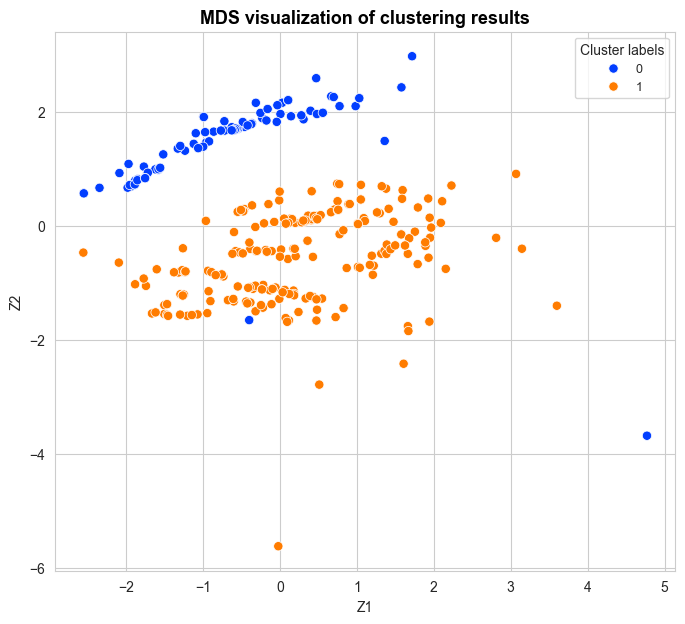

In [373]:
clustering_MDS_plot_one_method(X_mds=X_mds, y_pred=fold_sample_dist_clust.labels_[sample_idx], 
                               y_true=None, title="MDS visualization of clustering results", 
                               accuracy=None, time=None, 
                               figsize=(8,7), bbox_to_anchor=(1,1), 
                               title_size=13, title_weight='bold', 
                               points_size=45, title_height=1, 
                               save=False, legend_size=9)

### `clustering_MDS_plot_multiple_methods`

In [374]:
from db_robust_clust.plots import clustering_MDS_plot_multiple_methods
from db_robust_clust.metrics import adjusted_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import time

In [375]:
###############################################################################

kmedoids_method = 'pam'
metric = 'ggower'
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'
clustering_method = KMedoids(
    n_clusters=n_clusters, 
    metric='precomputed', 
    method=kmedoids_method, 
    init='build', 
    max_iter=100, 
    random_state=123
)
sample_dist_clust = SampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    frac_sample_size=0.1,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05
)
start_time = time.time()
sample_dist_clust.fit(X)
predicted_clusters_sample_dist_clust = sample_dist_clust.labels_
time_fast_kmedoids = time.time() - start_time

###############################################################################

fold_sample_dist_clust = FoldSampleDistClustering(
    clustering_method = clustering_method,
    metric = metric,
    n_splits=5, 
    shuffle=True,
    frac_sample_size=0.1,
    meta_frac_sample_size=0.8,
    random_state=123,
    stratify=False,
    p1=p1, p2=p2, p3=p3,
    d1=d1, d2=d2, d3=d3, 
    robust_method='trimmed', alpha=0.05,
)
start_time = time.time()
fold_sample_dist_clust.fit(X=X) 
predicted_clusters_fold_sample_dist_clust = fold_sample_dist_clust.labels_
time_fold_fast_kmedoids = time.time() - start_time

###############################################################################

start_time = time.time()
kmeans = KMeans(n_clusters=n_clusters, random_state=123, init='k-means++', n_init='auto', max_iter=300)
kmeans.fit(X)
predicted_clusters_kmeans = kmeans.labels_
time_kmeans = time.time() - start_time

###############################################################################

start_time = time.time()
gmm = GaussianMixture(n_components=n_clusters, random_state=123)
gmm.fit(X)
predicted_clusters_gmm = gmm.predict(X)
time_gmm = time.time() - start_time

###############################################################################

start_time = time.time()
kmedoids = KMedoids(n_clusters=n_clusters, metric='euclidean', method='pam', init='build', max_iter=100, random_state=123)
kmedoids.fit(X)
predicted_clusters_kmedoids = kmedoids.predict(X)
time_kmedoids = time.time() - start_time

###############################################################################

adj_accuracy_sample_dist_clust, adj_predicted_clusters_sample_dist_clust = adjusted_score(y_pred=predicted_clusters_sample_dist_clust, y_true=y, metric=balanced_accuracy_score)
adj_accuracy_fold_sample_dist_clust, adj_predicted_clusters_fold_sample_dist_clust = adjusted_score(y_pred=predicted_clusters_fold_sample_dist_clust, y_true=y, metric=balanced_accuracy_score)
adj_accuracy_kmeans, adj_predicted_clusters_kmeans = adjusted_score(y_pred=predicted_clusters_kmeans, y_true=y, metric=balanced_accuracy_score)
adj_accuracy_gmm, adj_predicted_clusters_gmm = adjusted_score(y_pred=predicted_clusters_gmm, y_true=y, metric=balanced_accuracy_score)
adj_accuracy_kmedoids, adj_predicted_clusters_kmedoids = adjusted_score(y_pred=predicted_clusters_kmedoids, y_true=y, metric=balanced_accuracy_score)


In [376]:
y_pred_dict = {
    'SampleDistClust-RobustGGower-KMedoidsPAM': adj_predicted_clusters_sample_dist_clust[sample_idx],
    'FoldSampleDistClust-RobustGGower-KMedoidsPAM': adj_predicted_clusters_fold_sample_dist_clust[sample_idx],
    'Kmeans': adj_predicted_clusters_kmeans[sample_idx],
    'GMM': adj_predicted_clusters_gmm[sample_idx],
    'Kmedoids': adj_predicted_clusters_kmedoids[sample_idx]
}

accuracy_dict = {
    'SampleDistClust-RobustGGower-KMedoidsPAM': adj_accuracy_sample_dist_clust,
    'FoldSampleDistClust-RobustGGower-KMedoidsPAM': adj_accuracy_fold_sample_dist_clust,
    'Kmeans': adj_accuracy_kmeans,
    'GMM': adj_accuracy_gmm,
    'Kmedoids': adj_accuracy_kmedoids,
}

time_dict = {
    'SampleDistClust-RobustGGower-KMedoidsPAM': time_fast_kmedoids,
    'FoldSampleDistClust-RobustGGower-KMedoidsPAM': time_fold_fast_kmedoids,
    'Kmeans': time_kmeans,
    'GMM': time_gmm,
    'Kmedoids': time_kmedoids,
}

c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\seaborn\_core\data.py:313: UserWarning: Conversion using Arrow PyCapsule Interface failed due to missing PyArrow>=14 dependency, falling back to (deprecated) interchange protocol. We recommend that you install PyArrow>=14.0.0.
  return pd.api.interchange.from_dataframe(data)
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\seaborn\_core\data.py:313: UserWarning: Conversion using Arrow PyCapsule Interface failed due to missing PyArrow>=14 dependency, falling back to (deprecated) interchange protocol. We recommend that you install PyArrow>=14.0.0.
  return pd.api.interchange.from_dataframe(data)
c:\Users\fscielzo\Documents\Proyectos\db_robust_clust-package\.venv\Lib\site-packages\seaborn\_core\data.py:313: UserWarning: Conversion using Arrow PyCapsule Interface failed due to missing PyArrow>=14 dependency, falling back to (deprecated) interchange protocol. We recomme

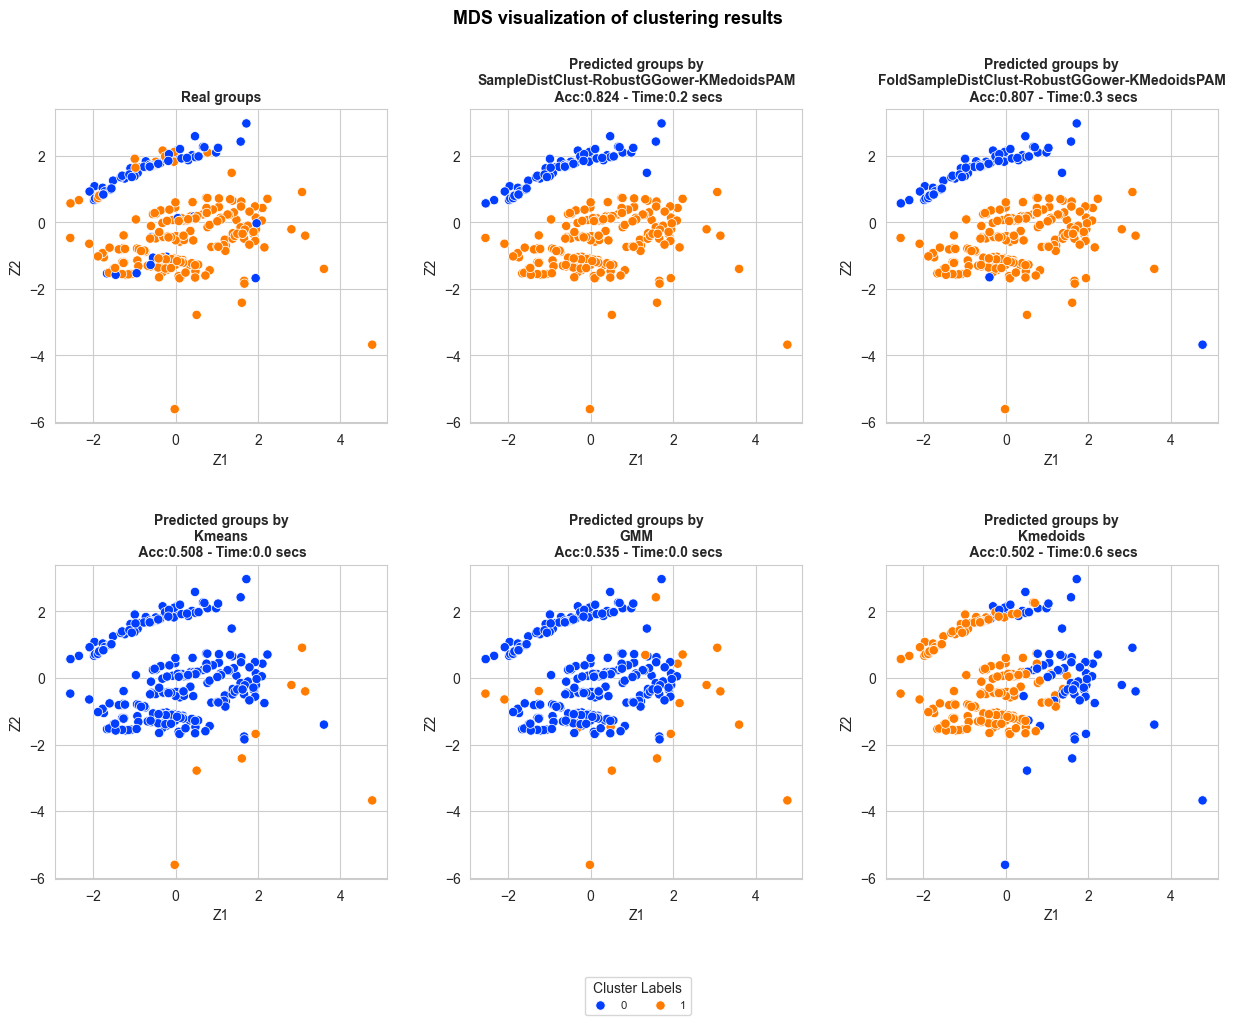

In [377]:
clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[sample_idx],
                                     title="MDS visualization of clustering results", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(15,10), bbox_to_anchor=(0.68,-1.9), 
                                     title_size=13, subtitles_size=10,
                                     title_weight='bold', points_size=45, 
                                     title_height=0.98, legend_size=8, 
                                     wspace=0.25, hspace=0.45, 
                                     legend_title='Cluster Labels',
                                     n_cols_legend=4, save=False)